# **Import libraries**

In [25]:
import json
import pandas as pd
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # This is the essential 3D import
import numpy as np

# **Initialize variables**

In [26]:
json_file_path = '/content/player_ball_video.json'
excel_file_path = "ball_tracking_data.xlsx"

df = pd.DataFrame(columns=['frame', 'x', 'y', 'confidence'])

# **Run code**

In [27]:
if not os.path.exists(json_file_path):
  print(f"Error: Input JSON file not found at {json_file_path}")

try:
  with open(json_file_path, 'r') as f:
    data = json.load(f)
except json.JSONDecodeError:
  print(f"Error: Could not decode JSON from {json_file_path}")
except Exception as e:
  print(f"An unexpected error occurred while reading the JSON file: {e}")

In [28]:
try:
  df = pd.read_excel(excel_file_path)
except FileNotFoundError:
  print(f"Error: The file '{excel_file_path}' was not found.")

required_cols = ['frame', 'x', 'y']

if not all(col in df.columns for col in required_cols):
  print(f"Error: The DataFrame must contain columns: {required_cols}")
  print(f"Columns found: {list(df.columns)}")

In [29]:
frame_data_key = None

for key, value in data.items():
  if isinstance(value, list) and key not in ['frame_offset', 'time_offset']:
    frame_data_key = key
    break

if not frame_data_key:
    print("Error: Could not find the main prediction data list in the JSON structure.")

In [34]:
extracted_data = []

detection_frames = data.get(frame_data_key, [])

for detection in detection_frames:
  if detection.get('class_id') == 'ball':
    x = (detection.get('x_min')+detection.get('x_max'))/2
    y = (detection.get('y_min')+detection.get('y_max'))/2
    confidence = detection.get('confidence')

    row = {
        'frame': detection.get('frame_id'), # Use frame_id from detection
        'x': x,
        'y': y,
        'confidence': confidence
    }
    extracted_data.append(row)

In [35]:
df = pd.DataFrame(extracted_data)

if df.empty:
  print(f"Warning: No ball detections found in the JSON file.")

In [41]:
df = df.sort_values(by='frame')
# If 'frame' is already the index, reset it to a column first
if df.index.name == 'frame' and 'frame' not in df.columns:
    df = df.reset_index()

# Now drop duplicates based on the 'frame' column
df = df.drop_duplicates(subset=['frame'], keep='first')

# Set 'frame' back as the index
df = df.set_index('frame')

start_frame = df.index.min()
end_frame = df.index.max()
print(f"Detected frame range: {start_frame} to {end_frame}")

full_index = pd.RangeIndex(start=start_frame, stop=end_frame + 1, step=1)
df_reindexed = df.reindex(full_index)

Detected frame range: 0 to 283


In [42]:
missing_count_x = df_reindexed['x'].isnull().sum()
print(f"Identified {missing_count_x} missing frame(s) for interpolation.")

missing_count_y = df_reindexed['y'].isnull().sum()
print(f"Identified {missing_count_y} missing frame(s) for interpolation.")

df_interpolated = df_reindexed[['x', 'y']].interpolate(method='linear', limit=5, limit_direction='both')

df_interpolated = df_interpolated.reset_index(names=['frame'])

output_file_name = f"interpolated_{excel_file_path}"
df_interpolated.to_excel(output_file_name, index=False)

print(f"Success! Interpolated data saved to: {output_file_name}")
print("The new file contains all frames from the start to the end.")

"""
    # Optionally, show a snippet of the changes
    original_missing_frames = df_reindexed[df_reindexed[x_col].isna()].index.tolist()
    if original_missing_frames:
        print("\nExample of Interpolated Results (based on original missing frames):")
        # Get data for the frames that were originally missing
        sample_data = df_interpolated[df_interpolated[frame_col].isin(original_missing_frames)]
        print(sample_data.to_string(index=False))"""

Identified 118 missing frame(s) for interpolation.
Identified 118 missing frame(s) for interpolation.
Success! Interpolated data saved to: interpolated_ball_tracking_data.xlsx
The new file contains all frames from the start to the end.


'    \n    # Optionally, show a snippet of the changes\n    original_missing_frames = df_reindexed[df_reindexed[x_col].isna()].index.tolist()\n    if original_missing_frames:\n        print("\nExample of Interpolated Results (based on original missing frames):")\n        # Get data for the frames that were originally missing\n        sample_data = df_interpolated[df_interpolated[frame_col].isin(original_missing_frames)]\n        print(sample_data.to_string(index=False))'

In [43]:
try:
  df.to_excel(excel_file_path, index=False, sheet_name='Ball Detections')
  print(f"Successfully extracted {len(df)} ball detections.")
  print(f"Data saved to Excel file: {df}")

except Exception as e:
  print(f"Error occurred while saving to Excel: {e}")

Successfully extracted 166 ball detections.
Data saved to Excel file:             x      y  confidence
frame                           
0      1070.0  368.0    0.597126
1      1067.5  369.5    0.605423
2      1066.0  372.5    0.663537
3      1063.5  375.5    0.646803
4      1062.0  378.5    0.514805
...       ...    ...         ...
279     804.0  292.0    0.615904
280     805.0  291.5    0.599906
281     807.0  291.0    0.557880
282     808.0  291.0    0.525680
283     809.5  290.5    0.449713

[166 rows x 3 columns]


# **Plot data**

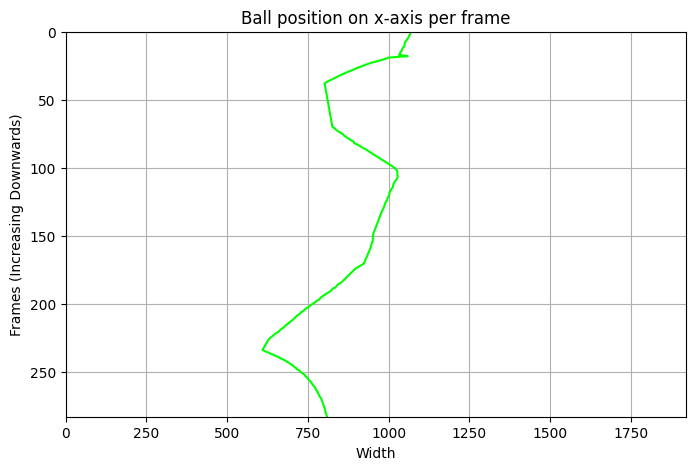

<Figure size 640x480 with 0 Axes>

In [44]:
# Image Size (W, H): (1920, 1080)

plt.figure(figsize=(8, 5))
plt.plot(df['x'], df.index, color='lime') # Plotting ball trajectory on x-axis

plt.xlim(0, 1920)
plt.ylim(df.index.max(),0)

plt.title('Ball position on x-axis per frame')
plt.xlabel('Width')
plt.ylabel('Frames (Increasing Downwards)')
plt.grid(True)

plt.show()

plt.savefig('x_ball_per_frame_plot.png')

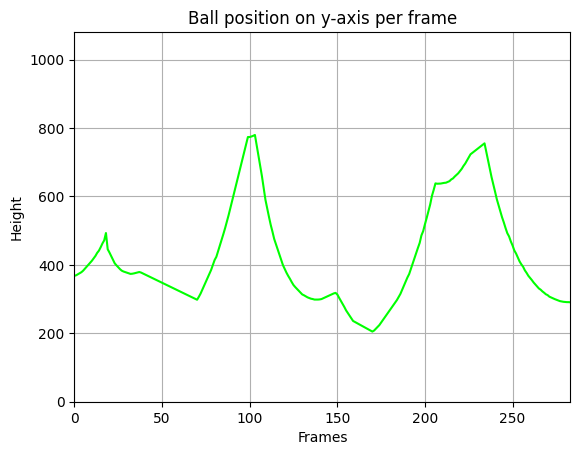

In [46]:
plt.plot(df.index, df['y'], color='lime') # Plotting ball trajectory on y-axis

plt.ylim(0, 1080) # Fix: Use df['x'].max() to get a single maximum value
plt.xlim(0, df.index.max()) # Correct X-axis limit for frames

plt.title('Ball position on y-axis per frame')
plt.xlabel('Frames')
plt.ylabel('Height')
plt.grid(True)

plt.savefig('y_ball_per_frame_plot.png')

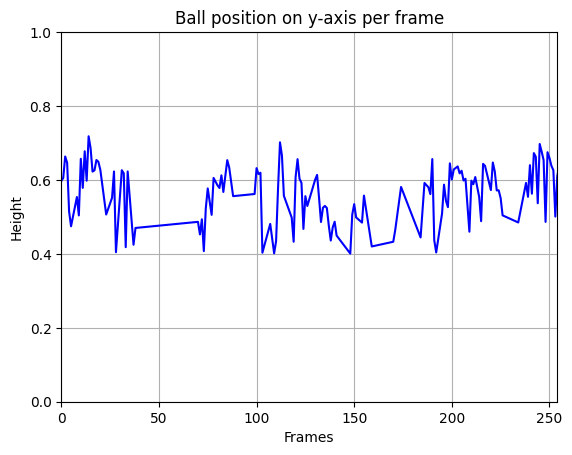

In [48]:
plt.plot(df.index, df['confidence'], color='blue') # Plotting ball trajectory on x-axis

plt.ylim(0, 1)
plt.xlim(0,int(len(detection_frames)/3))

plt.title('Ball position on y-axis per frame')
plt.xlabel('Frames')
plt.ylabel('Height')
plt.grid(True)

plt.savefig('y_ball_per_frame_plot.png')

In [51]:
import pandas as pd
import numpy as np
import plotly.express as px

def create_plotly_3d_scatter(df):
    """
    Creates a highly interactive 3D scatter plot using Plotly Express.
    X = 'x', Y = 'y', Z = 'frame'.

    Args:
        df (pd.DataFrame): The DataFrame containing 'x', 'y', and 'frame' columns.
    """

    # --- 1. Create the Plotly Figure ---
    fig = px.scatter_3d(
        df,
        x='x',            # X-Axis data
        y=df.index,            # Y-Axis data
        z='y',        # Z-Axis data (Frame Number)
        color=df.index,    # Color the points based on frame number
        title='Interactive 3D Ball Trajectory (Plotly)',
        height=700        # Adjust plot height
    )

    # --- 2. Define Axis Limits and Invert Y-Axis ---

    # Get the required min/max values
    x_min, x_max = 0, 1920
    y_min, y_max = 0, 1080

    # Configure the layout and axes
    fig.update_layout(
        scene = {
            # X-axis limits
            'xaxis': dict(range=[x_min, x_max], title='X Coordinate'),

            # Y-axis limits (Setting y_max first effectively inverts the axis)
            # Plotly handles inversion slightly differently but setting the range
            # often gives the desired look in 3D views.
            'yaxis': dict(range = (0, len(detection_frames)/3), title='Frame Number'),

            # Z-axis limits (Frame number)
            'zaxis': dict(range=[y_min, y_max], title='Y Coordinate'),
        },
        margin=dict(l=0, r=0, b=0, t=50)
    )

    # --- 3. Display the Plot ---
    fig.show()

create_plotly_3d_scatter(df)